### Toulouse/Squidguard Model


In [1]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
np.random.seed(1)
tf.random.set_seed(2)

NGRAMS = 2
FEATURE_LEN = 128
EPOCHS = 5

# Blacklists
df = pd.read_csv('../train-test/data/blacklists.csv.bz2')
#df = df.sample(100000, random_state=21)
df


,domain,blacklists_cat
0,59.52.114.68,phishing
1,eroticalee1.blogspot.ru,adult
2,jstanothergrly.blogspot.com.br,adult
3,youmightbest.tk,redirector|strict_redirector|strong_redirector
4,jstanothergrly.blogspot.com.by,adult
...,...,...
2140116,aqnjmquscyduyhw.blogspot.com.ng,adult
2140117,sexyhotmalemodels.blogspot.ug,adult
2140118,sex-in-sydney.blogspot.com.cy,adult
2140119,ipornx.blogspot.pe,adult


In [2]:
df['cat_count'] = df.blacklists_cat.apply(lambda c: len(c.split('|')))
sdf = df[df.cat_count == 1]
sdf

,domain,blacklists_cat,cat_count
0,59.52.114.68,phishing,1
1,eroticalee1.blogspot.ru,adult,1
2,jstanothergrly.blogspot.com.br,adult,1
4,jstanothergrly.blogspot.com.by,adult,1
5,edwardmax1.blogspot.com.au,adult,1
...,...,...,...
2140116,aqnjmquscyduyhw.blogspot.com.ng,adult,1
2140117,sexyhotmalemodels.blogspot.ug,adult,1
2140118,sex-in-sydney.blogspot.com.cy,adult,1
2140119,ipornx.blogspot.pe,adult,1


In [3]:
dom_group = sdf.groupby('blacklists_cat').agg({'domain': 'count'})
dom_group

,domain
blacklists_cat,
adult,1870741
agressif,304
arjel,11
associations_religieuses,1
astrology,27
audio-video,2977
bank,1689
bitcoin,251
blog,1425


### Take out categories that have less than 1000 domains.

In [4]:
filter_cat = list(dom_group[dom_group.domain > 1000].index)
#filter_cat = list(dom_group[dom_group.domain > 100].index)

### Take out categories that have recall < 0.3 (based on previous iterations of the model)

In [5]:
excat = ['audio-video', 'blog', 'dating', 'liste_bu', 'sports', 'publicite']

In [6]:
filter_cat = [x for x in filter_cat if x not in excat]
filter_cat

['adult',
 'bank',
 'gambling',
 'games',
 'malware',
 'phishing',
 'press',
 'shopping']

In [7]:
sdf.loc[sdf.blacklists_cat.isin(filter_cat) == False, 'blacklists_cat'] = 'others'

/opt/venv37/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
sdf.groupby('blacklists_cat').agg({'domain': 'count'})

,domain
blacklists_cat,
adult,1870741
bank,1689
gambling,1012
games,9357
malware,4463
others,21441
phishing,62712
press,4410
shopping,36331


## Preprocessing the input data

In [9]:
# build n-gram list
#vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
vect = CountVectorizer(analyzer='char', ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
a = vect.fit_transform(sdf.domain)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)


def find_ngrams(text, n):
    a = zip(*[text[i:] for i in range(n)])
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.domain.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

num_words = 1498


In [10]:
print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
class_labels = sdf.blacklists_cat.astype('category').cat.categories
y = np.array(sdf.blacklists_cat.astype('category').cat.codes)

# Split train and test dataset
X_train_valid,  X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train,  X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=21, stratify=y_train_valid)
#X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# backup
y_train_lab = y_train
y_test_lab = y_test

Max feature len = 137, Avg. feature len = 23


In [11]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 374149,
 1: 338,
 2: 202,
 3: 1871,
 4: 893,
 5: 4288,
 6: 12543,
 7: 882,
 8: 7266}

In [12]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 1197274,
 1: 1081,
 2: 648,
 3: 5989,
 4: 2856,
 5: 13722,
 6: 40135,
 7: 2822,
 8: 23252}

## Train a LSTM model

In [13]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = FEATURE_LEN # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train_valid), 'train+valid sequences')
print(len(X_train), 'train sequences')
print(len(X_valid), 'valid sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train_valid = sequence.pad_sequences(X_train_valid, maxlen=feature_len)
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_valid = sequence.pad_sequences(X_valid, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train_valid shape:', X_train_valid.shape)
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

n_classes = np.max(y_train_valid) + 1
print(n_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train_valid = keras.utils.to_categorical(y_train_valid, n_classes)
y_train = keras.utils.to_categorical(y_train, n_classes)
y_valid = keras.utils.to_categorical(y_valid, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)
print('y_train_valid shape:', y_train_valid.shape)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

Using TensorFlow backend.


1609724 train+valid sequences
1287779 train sequences
321945 valid sequences
402432 test sequences
Pad sequences (samples x time)
X_train_valid shape: (1609724, 128)
X_train shape: (1287779, 128)
X_valid shape: (321945, 128)
X_test shape: (402432, 128)
9 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train_valid shape: (1609724, 9)
y_train shape: (1287779, 9)
y_valid shape: (321945, 9)
y_test shape: (402432, 9)


In [14]:
def create_model():
    print('Build model...')

    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=feature_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(n_classes, activation='softmax'))

    # try using different optimizers and different optimizer configs
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    #print(model.summary())
    return model

In [15]:
import matplotlib.pyplot as plt

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score, log_loss)
from sklearn.linear_model import LogisticRegression

In [16]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data

clf = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=batch_size, verbose=1)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

Build model...


/opt/venv37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
1609724/1609724 [==============================] - 6847s 4ms/step - loss: 0.1714 - accuracy: 0.9446
Epoch 2/5
1609724/1609724 [==============================] - 6853s 4ms/step - loss: 0.1447 - accuracy: 0.9520
Epoch 3/5
1609724/1609724 [==============================] - 6840s 4ms/step - loss: 0.1378 - accuracy: 0.9541
Epoch 4/5
1609724/1609724 [==============================] - 6784s 4ms/step - loss: 0.1346 - accuracy: 0.9551
Epoch 5/5
402432/402432 [==============================] - 527s 1ms/step


In [17]:
# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=batch_size, verbose=1)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)

Build model...


/opt/venv37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
1287779/1287779 [==============================] - 5577s 4ms/step - loss: 0.1748 - accuracy: 0.9436
Epoch 2/5
1287779/1287779 [==============================] - 5497s 4ms/step - loss: 0.1475 - accuracy: 0.9510
Epoch 3/5
1287779/1287779 [==============================] - 5713s 4ms/step - loss: 0.1395 - accuracy: 0.9534
Epoch 4/5
1287779/1287779 [==============================] - 6778s 5ms/step - loss: 0.1353 - accuracy: 0.9549
Epoch 5/5
402432/402432 [==============================] - 524s 1ms/step


In [18]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1287779, 128), (1287779, 9), (321945, 128), (321945, 9))

In [ ]:
sig_clf = CalibratedClassifierCV(clf, method="isotonic", cv="prefit")
sig_clf.fit(X_valid, np.argmax(y_valid, axis=1))
sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(y_test, sig_clf_probs)

135296/402432 [=========>....................] - ETA: 5:47

In [20]:
score, sig_score

(0.12585416363862198, 0.17057041644045084)

In [21]:
sig_clf_pred = sig_clf.predict(X_test)

402432/402432 [==============================] - 519s 1ms/step


In [22]:
print("\tPrecision: %1.3f" % precision_score(np.argmax(y_test, axis=1), sig_clf_pred, average='macro'))
print("\tRecall: %1.3f" % recall_score(np.argmax(y_test, axis=1), sig_clf_pred, average='macro'))
print("\tF1: %1.3f\n" % f1_score(np.argmax(y_test, axis=1), sig_clf_pred, average='macro'))

fraction_of_positives, mean_predicted_value = \
    calibration_curve(y_test[:, 0], sig_clf_probs[:, 0], n_bins=10)

	Precision: 0.740
	Recall: 0.527
	F1: 0.604



In [23]:
clf_pred = clf.predict(X_test)

402432/402432 [==============================] - 518s 1ms/step


In [24]:
print("\tPrecision: %1.3f" % precision_score(np.argmax(y_test, axis=1), clf_pred, average='macro'))
print("\tRecall: %1.3f" % recall_score(np.argmax(y_test, axis=1), clf_pred, average='macro'))
print("\tF1: %1.3f\n" % f1_score(np.argmax(y_test, axis=1), clf_pred, average='macro'))

fraction_of_positives, mean_predicted_value = \
    calibration_curve(y_test[:, 0], clf_probs[:, 0], n_bins=10)

	Precision: 0.719
	Recall: 0.549
	F1: 0.608



## Confusion Matrix

In [34]:
y_pred = clf.predict(X_test)

402432/402432 [==============================] - 537s 1ms/step


In [35]:
target_names = list(sdf.blacklists_cat.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

       adult       0.97      0.99      0.98    374149
        bank       0.67      0.55      0.60       338
    gambling       0.39      0.56      0.46       202
       games       0.83      0.46      0.59      1871
     malware       0.92      0.49      0.64       893
      others       0.56      0.25      0.34      4288
    phishing       0.74      0.59      0.66     12543
       press       0.80      0.53      0.64       882
    shopping       0.59      0.52      0.55      7266

    accuracy                           0.96    402432
   macro avg       0.72      0.55      0.61    402432
weighted avg       0.95      0.96      0.95    402432

[[370705     22    107     72     11    448   1336     50   1398]
 [    69    185      1      0      0     19     46      0     18]
 [    47      0    113      3      0      1     20      1     17]
 [   711      2      9    859      0     72    113      1    104]
 [   220      5      0      1  

In [36]:
sig_y_pred = sig_clf.predict(X_test)

402432/402432 [==============================] - 535s 1ms/step


In [37]:
target_names = list(sdf.blacklists_cat.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), sig_y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

       adult       0.97      0.99      0.98    374149
        bank       0.70      0.53      0.60       338
    gambling       0.43      0.47      0.44       202
       games       0.86      0.45      0.59      1871
     malware       0.92      0.49      0.64       893
      others       0.56      0.25      0.35      4288
    phishing       0.75      0.58      0.66     12543
       press       0.84      0.50      0.63       882
    shopping       0.63      0.48      0.54      7266

    accuracy                           0.96    402432
   macro avg       0.74      0.53      0.60    402432
weighted avg       0.95      0.96      0.95    402432

[[370705     22    107     72     11    448   1336     50   1398]
 [    69    185      1      0      0     19     46      0     18]
 [    47      0    113      3      0      1     20      1     17]
 [   711      2      9    859      0     72    113      1    104]
 [   220      5      0      1  

In [46]:
def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

In [48]:
brier_multi(y_test, clf_probs)

0.060490668

In [49]:
brier_multi(y_test, sig_clf_probs)

0.06791789683460298

LSTM:
	Brier: 0.022
	Precision: 0.972
	Recall: 0.991
	F1: 0.981

LSTM:
	Brier: 0.001
	Precision: 0.925
	Recall: 0.494
	F1: 0.644

LSTM:
	Brier: 0.014
	Precision: 0.740
	Recall: 0.593
	F1: 0.658

LSTM + sigmoid:
	Brier: 0.027
	Precision: 0.970
	Recall: 0.992
	F1: 0.981

LSTM + sigmoid:
	Brier: 0.001
	Precision: 0.921
	Recall: 0.494
	F1: 0.643

LSTM + sigmoid:
	Brier: 0.015
	Precision: 0.753
	Recall: 0.584
	F1: 0.658



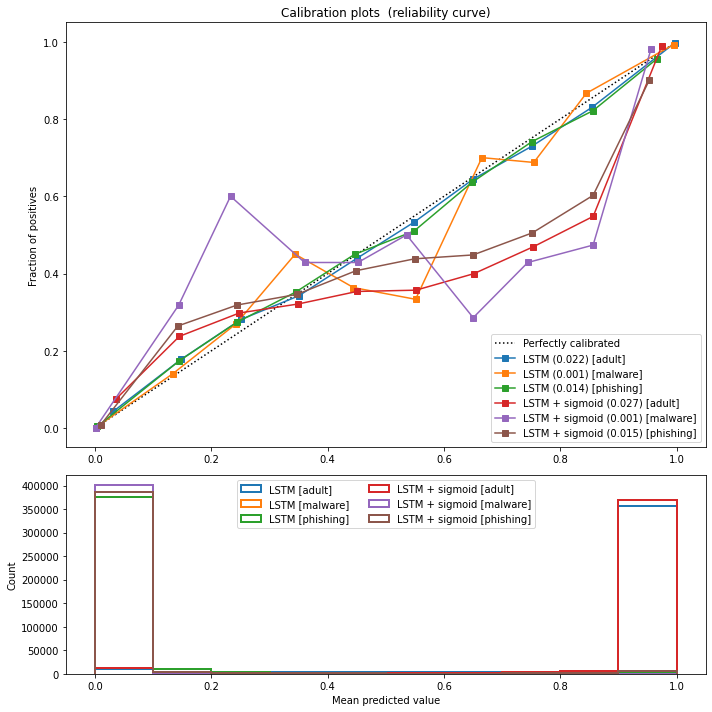

In [76]:
fig_index = 1

fig = plt.figure(fig_index, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for name, prob_pos, y_test2, y_pred2, target in [('LSTM', clf_probs, y_test, y_pred, 'adult'),
                                                 ('LSTM', clf_probs, y_test, y_pred, 'malware'),
                                                 ('LSTM', clf_probs, y_test, y_pred, 'phishing'),
                                                 ('LSTM + sigmoid', sig_clf_probs, y_test, sig_y_pred, 'adult'),
                                                 ('LSTM + sigmoid', sig_clf_probs, y_test, sig_y_pred, 'malware'),
                                                 ('LSTM + sigmoid', sig_clf_probs, y_test, sig_y_pred, 'phishing')]:
    i = target_names.index(target)
    clf_score = brier_score_loss(y_test2[:, i], prob_pos[:, i], pos_label=y_test2.max())
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_test2[:, i], y_pred2==i))
    print("\tRecall: %1.3f" % recall_score(y_test2[:, i], y_pred2==i))
    print("\tF1: %1.3f\n" % f1_score(y_test2[:, i], y_pred2==i))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test2[:, i], prob_pos[:, i], n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f) [%s]" % (name, clf_score, target))

    ax2.hist(prob_pos[:, i], range=(0, 1), bins=10, label='%s [%s]' % (name, target),
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

## Save model

In [79]:
y_score = clf_probs

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


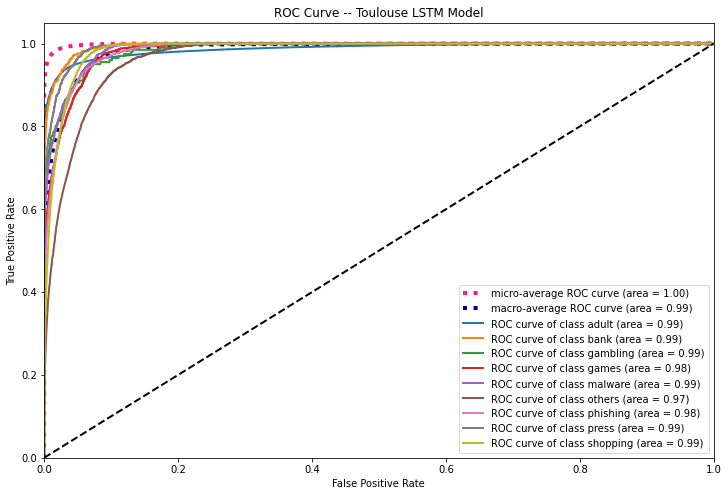

In [81]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(1, figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap("tab10")
colors = cycle([cmap(i) for i in range(n_classes)])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))
    if i >= 19:
        break

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- Toulouse LSTM Model')
plt.legend(loc="lower right")
plt.show()

In [82]:
fig.savefig('./roc-toulouse-lstm.eps', format='eps', dpi=300, bbox_inches="tight", orientation='landscape');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
y_score = sig_clf_probs

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


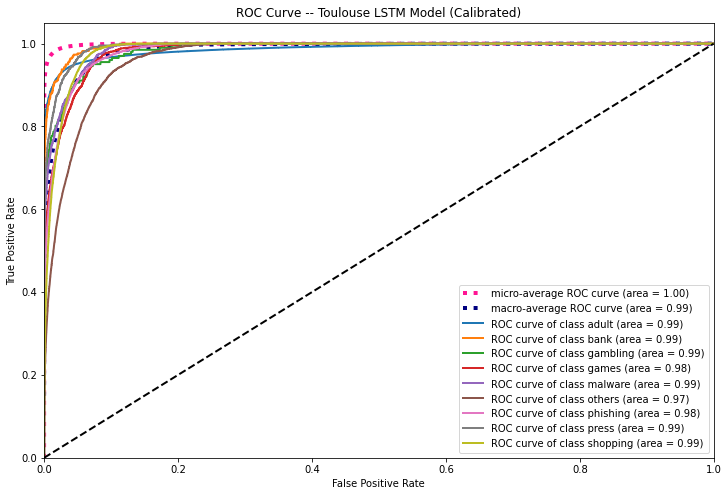

In [83]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(1, figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap("tab10")
colors = cycle([cmap(i) for i in range(n_classes)])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))
    if i >= 19:
        break

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- Toulouse LSTM Model (Calibrated)')
plt.legend(loc="lower right")
plt.show()

In [84]:
fig.savefig('./roc-toulouse-lstm-calibrated.eps', format='eps', dpi=300, bbox_inches="tight", orientation='landscape');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
